In [1]:
import numpy as np
import scipy.stats as stats
import scipy.linalg as la
import matplotlib.pyplot as plt

In [2]:
M = 15
epsilon = 0.9
V = V_prime = 1

In [3]:
i = np.arange(start=1, stop=M+1)
alpha_i = (M + 1 - i)/M
p_i = i/M # These are the initial p_i values (channel quality parameters)
q_i = epsilon*p_i/M

In [4]:
# Positive part of a column vector
def positive_part(a, n):
    return np.max(np.concatenate((np.reshape(x_i, (n,1)), np.zeros((n,1))), axis=1), axis=1)

# Calculate average weighted sum aoi
def average_weighted_sum_aoi(d_i_k, M, K, alpha_i):
    I_i = [set() for w in range(M)] # set of inter-delivery times
    h_avg_i = np.zeros(M) # per-node time-average AoI
    J_avg = 0 # average weighted sum AoI
    
    for y in range(M):
        delivery_times = np.nonzero(d_i_k[y])[0] + 1
    
        # Add inter-delivery times to set
        last_delivery = 0
        for d_t in delivery_times:
            id_t = d_t - last_delivery
            I_i[y].add(id_t)
            last_delivery = d_t
            
            # AoI calculations
            h_avg_i[y] += ((id_t + 1)*id_t) / (2*K)
            
        # Add remaining slots to set
        rs_t = K - last_delivery
        I_i[y].add(rs_t)
    
        # AoI calculations
        h_avg_i[y] += ((rs_t + 1)*rs_t) / (2*K)
        J_avg += alpha_i[y]*h_avg_i[y]/M
        
    return J_avg

Scenarios:
1) p is fixed but unknown: Start with an initial value for p (equal for all nodes) and update estimate in each slot for the node that is scheduled
2) p is changing over time according to some deterministic pattern (might not be worth considering since this seems unrealistic)
3) p is changing over time as a random walk process (in which p is bounded as (0,1])

# Generate Probability Traces

In [5]:
K = 10000

In [6]:
# Generate M random walks
bernoulli_param = 0.5 # High value -> small frequent increases, large infrequent decreases; Low value -> small frequent decreases, large infrequent increases
volatility_param = 0.01 # How large the changes are (COMPARE RESULTS WITH DIFFERENT VALUES)

# Each Bernoulli RV is mean-shited so that its expected value is zero
bernoulli_rvs = volatility_param*(stats.bernoulli(p=bernoulli_param).rvs((M, K-1))-bernoulli_param)

p_i_k = np.zeros((M, K))
p_i_k[:, 0] = p_i
for slot in range(K-1):
    p_i_k[:, slot+1] = p_i_k[:, slot] + bernoulli_rvs[:, slot]

    # Enforce upper and lower bounds (0,1] (this is the feaasible set specified in Kadota 2019)
    p_i_k[:, slot+1] = np.where(p_i_k[:, slot+1] > 1, 1, p_i_k[:, slot+1])
    p_i_k[:, slot+1] = np.where(p_i_k[:, slot+1] < 0.01, 0.01, p_i_k[:, slot+1]) # 0.01 is close enough to zero

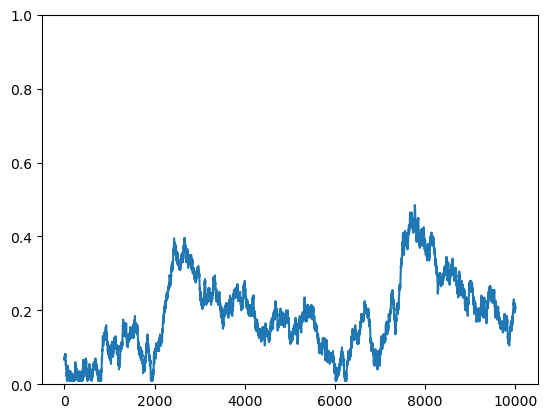

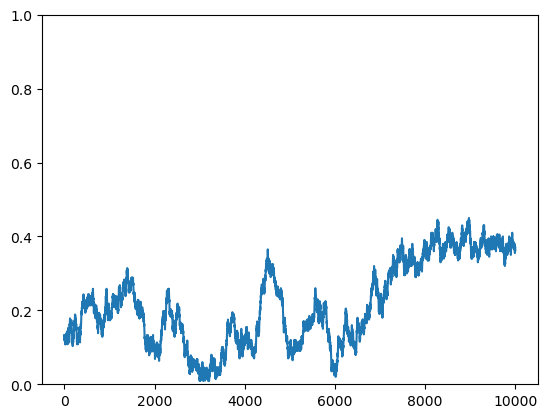

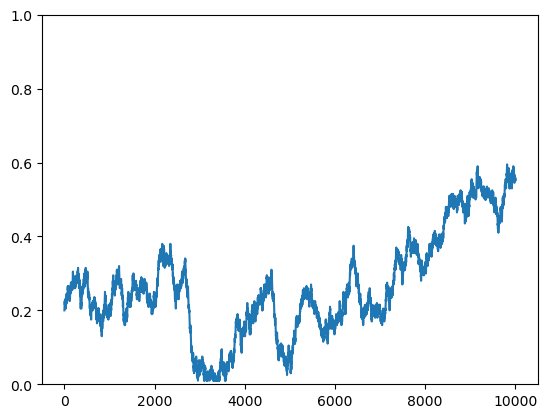

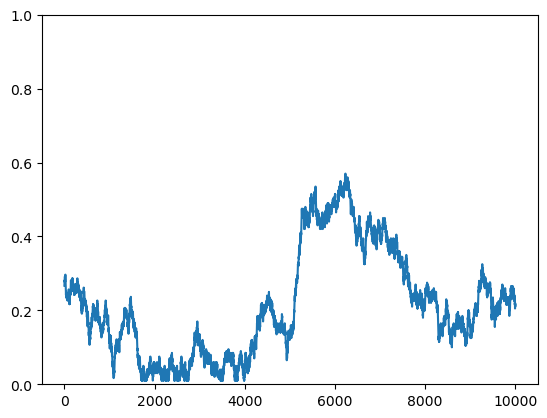

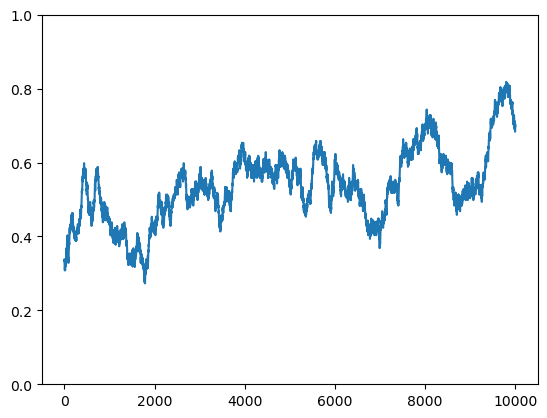

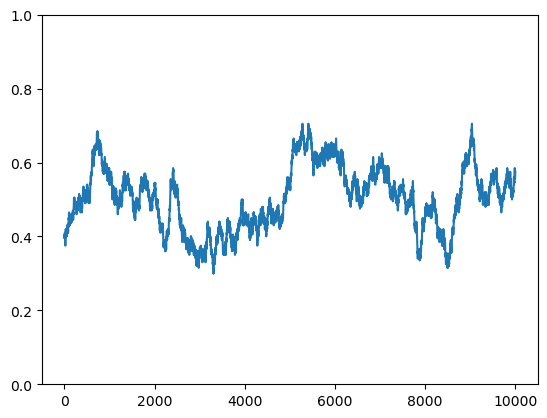

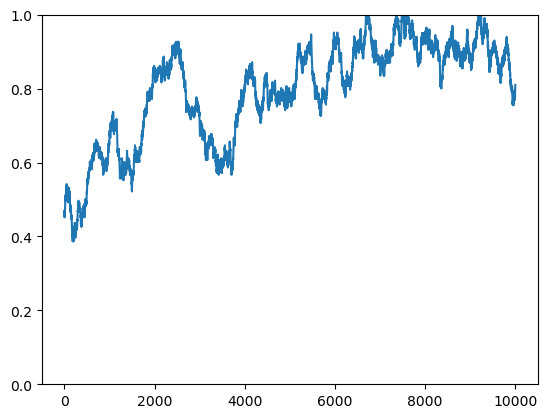

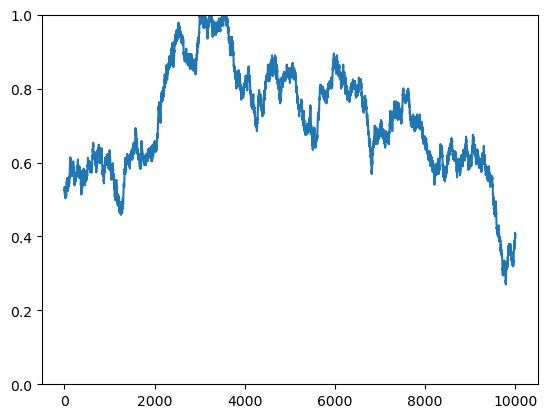

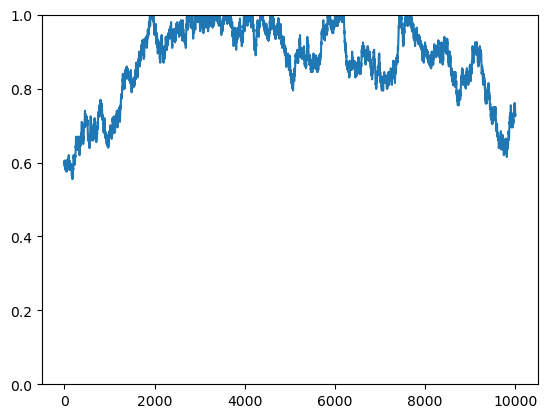

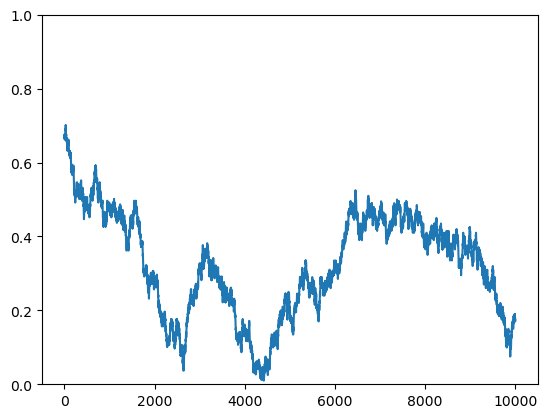

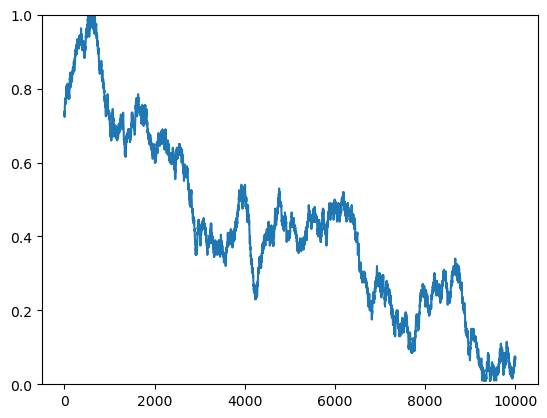

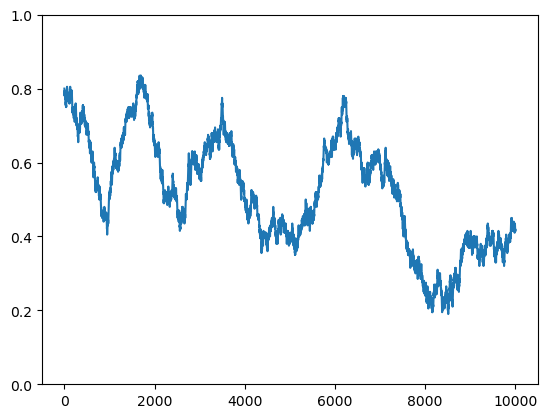

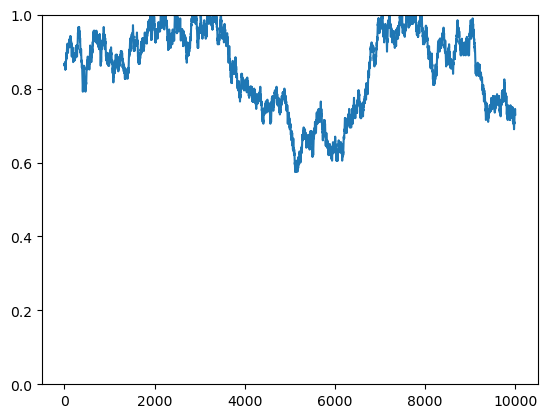

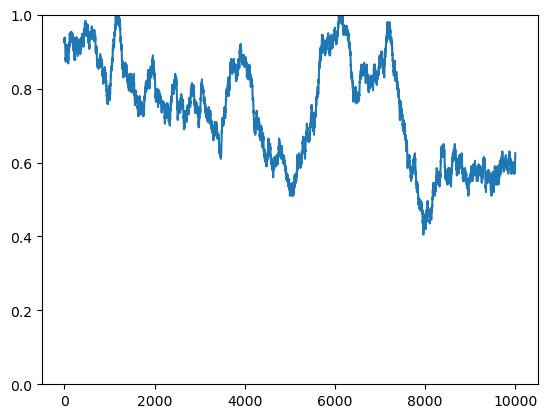

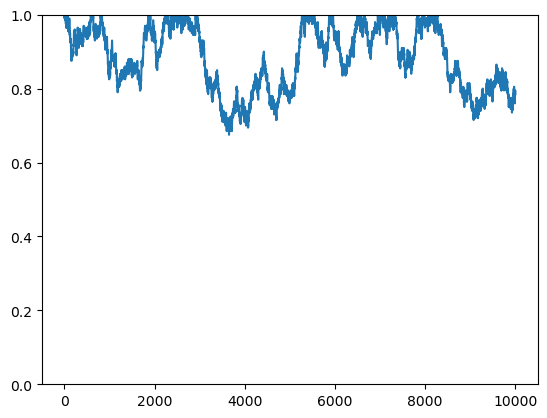

In [117]:
for src in range(M):
    plt.figure()
    plt.plot(np.arange(1,K+1), p_i_k[src, :])
    plt.ylim([0,1])

# Scheduling Algorithm 1: Optimal Stationary Randomized Policy 

## Simulation

In [104]:
G = 100
K_opt = 500 # Each K_opt slots, the algorithm will repeat the optimization using the current estimates of p_i
zeta = 0.05 # Averaging parameter. Need to establish which value works best, or could test across different values

In [112]:
J_avg_exp = 0

p_i_est_avg = np.zeros((M,K))

# Repeat simulation over G samples
for z in range(G):
    # Initialize estimates of p_i
    p_i_est = 0.5*np.ones(M)

    # Initialize transmission matrix
    d_i_k = np.zeros((M,K))

    # Generate outcome matrix that indicate whether transmission is successful in each time slot, assuming it is the selected time slot
    o_i_k = stats.bernoulli.rvs(p=p_i_k, size=(M,K))

    # For each optimization horizon
    for opt_hor in range(int(K/K_opt)):
        # Perfect knowledge
        #p_i_est = p_i_k[:, opt_hor*K_opt]

        #print("Starting Optimization")
        # Throughput requirements for optimization
        tp_sum = np.sum(q_i/p_i_est)
        # Check whether q is a feasible set of minimum throughput requirements
        q_i_opt = q_i
        if tp_sum > 1:
            #print("Minimum throughput requirements are infeasible")
            # Best we can do is solve the optimization problem with lower throughput requirements
            q_i_opt /= tp_sum
        
        # Solve optimization
        gamma_i = alpha_i*p_i_est/(M*q_i_opt**2)
        gamma_test = np.max(gamma_i)
        mu_i_test = q_i_opt/p_i_est * np.where(np.sqrt(gamma_i/gamma_test) > 1, np.sqrt(gamma_i/gamma_test), 1)
        S_test = np.sum(mu_i_test)

        #print(gamma_test)
        # This significantly speeds up optimization
        while S_test < 1:
            gamma = gamma_test
            mu_i = mu_i_test
            S = S_test
            
            gamma_test /= 2
            mu_i_test = q_i_opt/p_i_est * np.where(np.sqrt(gamma_i/gamma_test) > 1, np.sqrt(gamma_i/gamma_test), 1)
            S_test = np.sum(mu_i_test)
        #print(gamma)
        #print(gamma_test)
        while S < 1:
            gamma -= 0.1
            mu_i = q_i_opt/p_i_est * np.where(np.sqrt(gamma_i/gamma) > 1, np.sqrt(gamma_i/gamma), 1)
            S = np.sum(mu_i)
        #print(gamma)

        #print(np.sum(mu_i))
        #print(mu_i)

        subt_idx = np.argmax(mu_i)
        mu_i[subt_idx] -= (S - 1) # This is needed to make sure that mu_i exactly add up to one
        #if np.round(np.sum(mu_i), 8) != 1:
        #    print(np.sum(mu_i))
        #    print(mu_i)
        #    print(tp_sum)
        #    print(S-1)
        #    print(subt_idx)
        #print(np.sum(mu_i))
        #print(mu_i)
        #print("Finished Optimization")
        
        # Sample to determine which nodes will be scheduled in which slot (for all the slots in the opt horizon)
        i_k = stats.rv_discrete(a=1, b=M, values=(i, mu_i)).rvs(size=K_opt)

        for x in range(K_opt):
            # Calculate transmission matrix that indiciates which node has an arrival in this slot
            node_k_idx = i_k[x]-1
            arrival_successful = o_i_k[node_k_idx, x + opt_hor*K_opt]
            d_i_k[node_k_idx, x + opt_hor*K_opt] = arrival_successful

            # Update estimate for the scheduled node
            p_i_est[node_k_idx] = zeta*arrival_successful + (1-zeta)*p_i_est[node_k_idx]

            p_i_est_avg[:,x + opt_hor*K_opt] += p_i_est
    
    # Calculate average weighted sum AoI
    J_avg_exp += average_weighted_sum_aoi(d_i_k, M, K, alpha_i)

J_avg_exp /= G
p_i_est_avg /= G

In [113]:
J_avg_exp

25.41548996

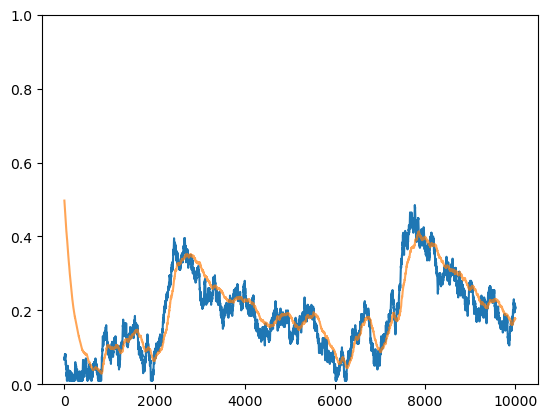

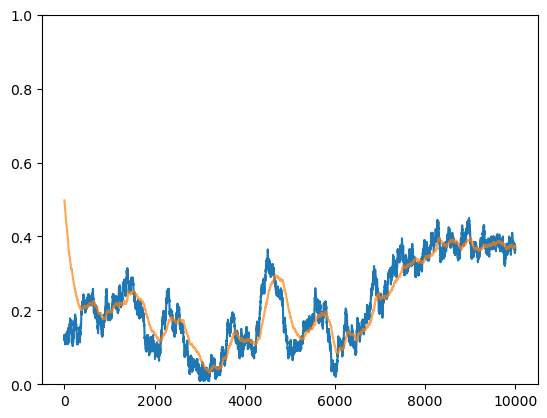

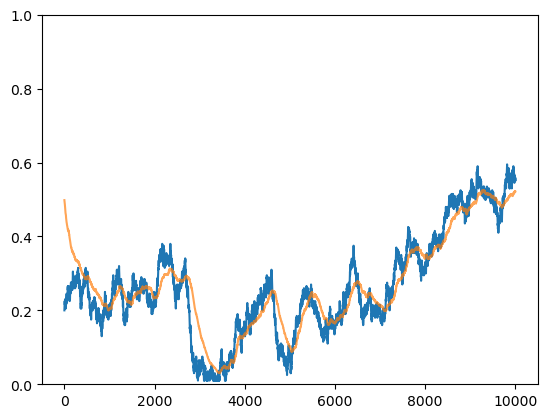

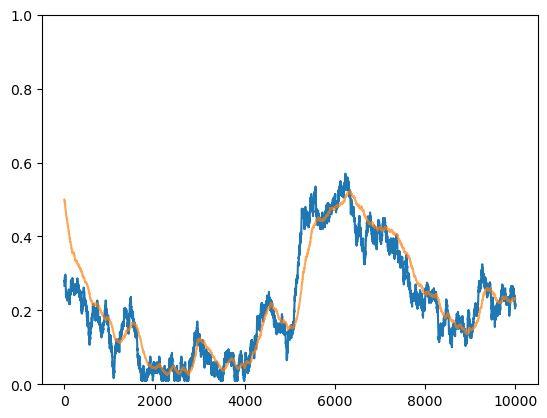

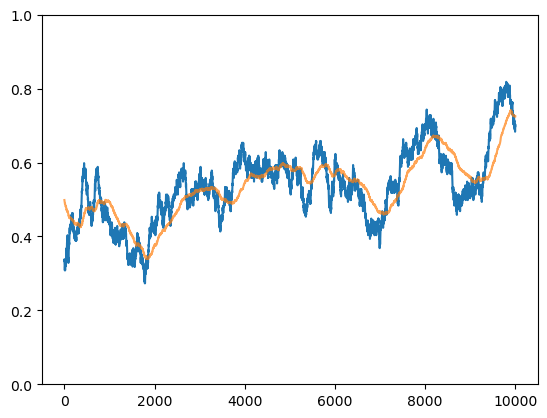

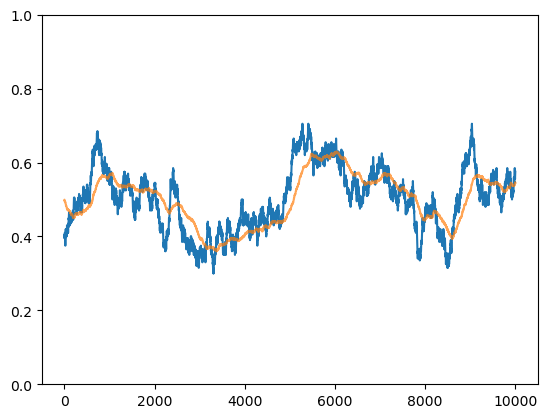

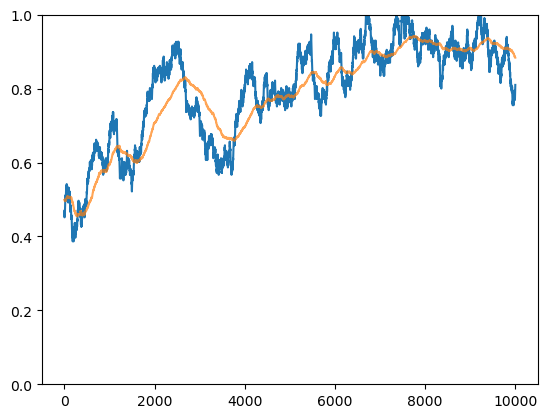

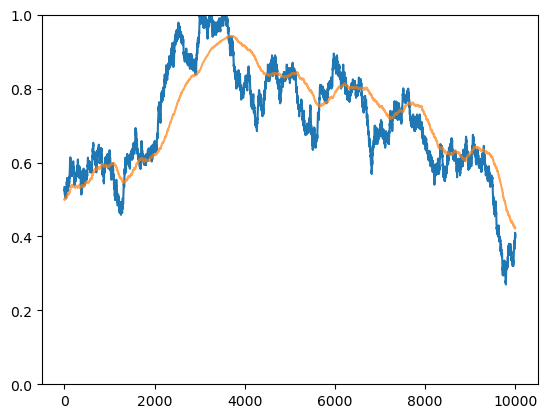

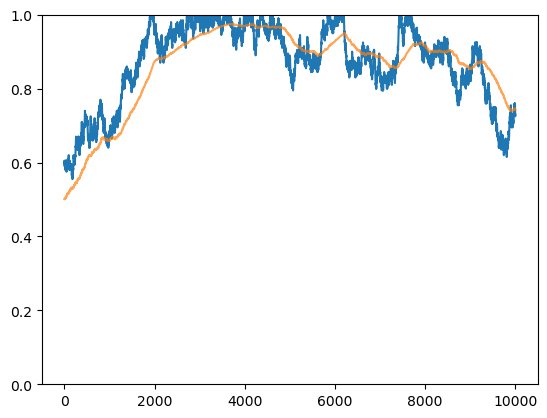

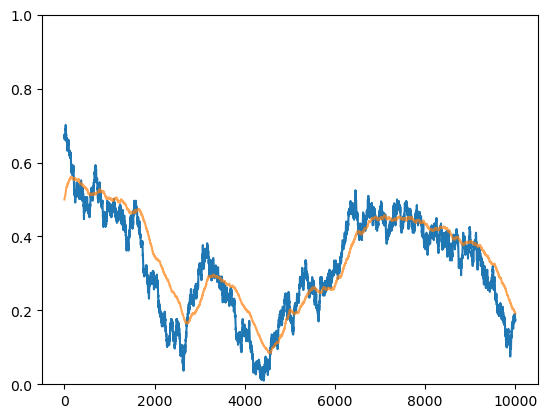

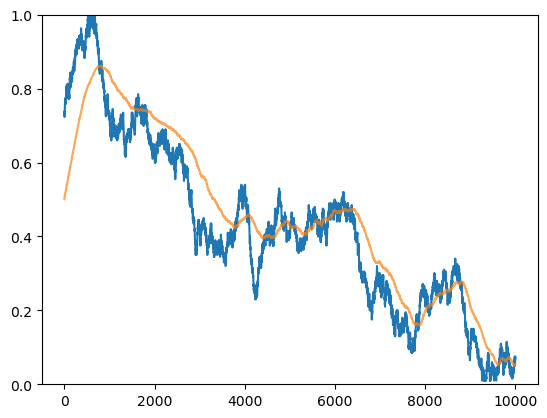

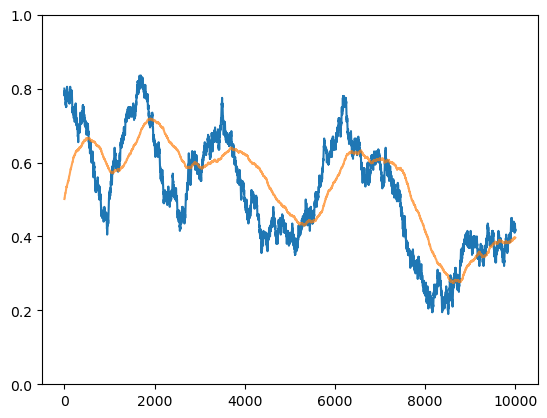

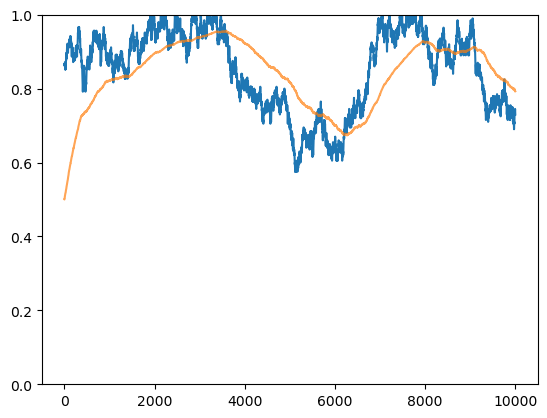

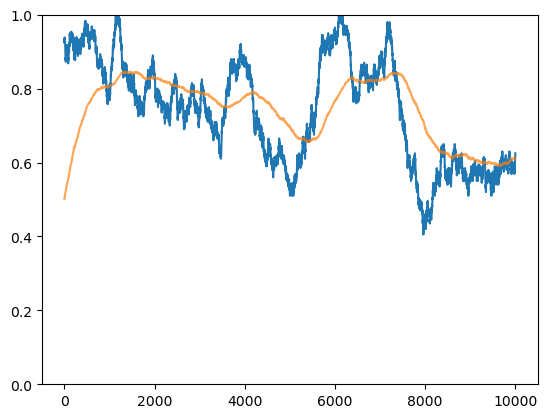

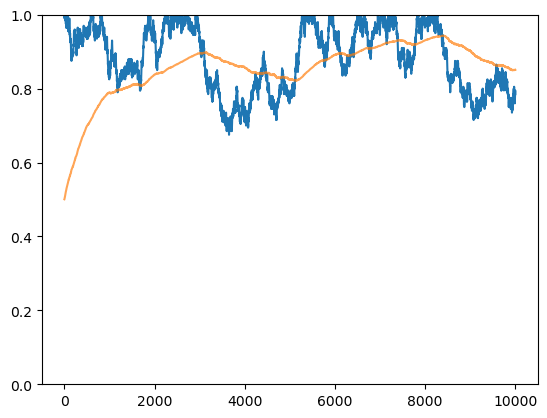

In [116]:
for src in range(M):
    plt.figure()
    plt.plot(np.arange(1,K+1), p_i_k[src, :])
    plt.plot(np.arange(1,K+1), p_i_est_avg[src, :], alpha=0.7)
    plt.ylim([0,1])

# Scheduling Algorithm 2: Max-Weight Policy

In [146]:
# Simulation parameters
K = 10000
G = 100

In [161]:
J_avg_exp = 0

# Repeat simulation
for z in range(G):
    # Initialize transmission matrix that indiciates which node has an arrival in which slot
    d_i_k = np.zeros((M,K))
    d_i_k_sum = np.zeros(M)
    q_i_sum = np.zeros(M)
    
    # Initialize AoI and throughput debt vectors
    h_i = np.ones(M)
    x_i = np.zeros(M)

    # Generate outcome matrix that indicates whether transmission is successful in each time slot, assuming it is the selected time slot
    o_i_k = stats.bernoulli.rvs(p=p_i_k, size=(M,K))

    # Initialize estimates of p_i
    p_i_est = 0.5*np.ones(M)
    
    # Loop over slots
    for k in np.arange(1,K+1):
        # Select node according to policy
        W_i = 0.5*alpha_i*p_i*(h_i**2+2*h_i) + V*p_i*np.where(x_i > 0, x_i, 0)
        i_sel = np.argmax(W_i)+1
        
        # Update transmission matrix based on whether transmission was successful or not
        d_i_k[i_sel-1, k-1] = o[i_sel-1, k-1]
        
        # Update AoI and throughput debt vectors
        h_i += 1
        if d_i_k[i_sel-1, k-1] == 1: # if transmission was successful
            h_i[i_sel-1] = 1
        d_i_k_sum += d_i_k[:,k-1]
        q_i_sum += q_i
        x_i = q_i_sum - d_i_k_sum
    
    #D_i = np.sum(d_i_k, axis=1)

    # Calculate average weighted sum AoI
    J_avg_exp += average_weighted_sum_aoi(d_i_k, M, K, alpha_i)
    
J_avg_exp /= G

In [163]:
J_avg_exp

14.505465479999996

# Scheduling Algorithm 3: Drift-Plus-Penalty Policy

In [165]:
# Simulation parameters
K = 10000
G = 100

In [166]:
# Repeated calculations
alpha_div_mu_i = (0.5)*alpha_i/mu_i

In [167]:
J_avg_exp = 0

# Repeat simulation
for z in range(G):
    # Initialize transmission matrix that indiciates which node has an arrival in which slot
    d_i_k = np.zeros((M,K))
    d_i_k_sum = np.zeros(M)
    q_i_sum = np.zeros(M)
    
    # Initialize AoI and throughput debt vectors
    h_i = np.ones(M)
    x_i = np.zeros(M)

    # Efficiently generate enough Bernoulli samples for each node
    bernoulli_samples = np.zeros((M,K))
    for node_idx in range(M):
        bernoulli_samples[node_idx, :] = stats.bernoulli.rvs(p=p_i[node_idx], size=K)
    
    # Loop over slots
    for k in np.arange(1,K+1):
        # Select node according to policy
        W_prime_i = alpha_div_mu_i*h_i + V_prime*p_i*np.where(x_i > 0, x_i, 0)
        i_sel = np.argmax(W_prime_i)+1
        
        # Update transmission matrix based on whether transmission was successful or not
        d_i_k[i_sel-1, k-1] = bernoulli_samples[i_sel-1,k-1]
        
        # Update AoI and throughput debt vectors
        h_i += 1
        if d_i_k[i_sel-1, k-1] == 1: # if transmission was successful
            h_i[i_sel-1] = 1
        d_i_k_sum += d_i_k[:,k-1]
        q_i_sum += q_i
        x_i = q_i_sum - d_i_k_sum
    
    #D_i = np.sum(d_i_k, axis=1)

    # Calculate average weighted sum AoI
    J_avg_exp += average_weighted_sum_aoi(d_i_k, M, K, alpha_i)
    
J_avg_exp /= G

In [168]:
J_avg_exp

15.282534097777775

# Scheduling Algorithm 4: Whittle's Index Policy

## Solving Optimization for Throughput Incentives

In [117]:
chi_i = alpha_i*p_i*((1/q_i)**2 - (1/p_i - 1/2)**2)/2
C = np.max(chi_i)
phi_i_inv = p_i*np.sqrt(2*np.min(np.concatenate((C*np.ones((M,1)), np.reshape(chi_i, (M, 1))), axis=1), axis=1) / (alpha_i*p_i) + (1/p_i - 1/2)**2)
S = np.sum(1/phi_i_inv)

while S < 1:
    C -= 0.1
    phi_i_inv = p_i*np.sqrt(2*np.min(np.concatenate((C*np.ones((M,1)), np.reshape(chi_i, (M, 1))), axis=1), axis=1) / (alpha_i*p_i) + (1/p_i - 1/2)**2)
    S = np.sum(1/phi_i_inv)
    
C_star = C
chi_i_star = np.min(np.concatenate((C_star*np.ones((M,1)), np.reshape(chi_i, (M, 1))), axis=1), axis=1)
theta_i = C_star - chi_i_star

In [118]:
print(theta_i)

[  0.           0.           0.          51.585      162.33333333
 236.17685185 288.93142857 328.505      359.2908642  383.925
 404.08484849 420.8887037  435.11076923 447.30404762 457.87407407]


## Simulation

In [174]:
# Simulation parameters
K = 100000
G = 100

In [175]:
# Repeated calculations
two_div_p_i = 2/p_i

In [176]:
J_avg_exp = 0

# Repeat simulation
for z in range(G):
    # Initialize transmission matrix that indiciates which node has an arrival in which slot
    d_i_k = np.zeros((M,K))
    d_i_k_sum = np.zeros(M)
    q_i_sum = np.zeros(M)
    
    # Initialize AoI and throughput debt vectors
    h_i = np.ones(M)
    x_i = np.zeros(M)

    # Efficiently generate enough Bernoulli samples for each node
    bernoulli_samples = np.zeros((M,K))
    for node_idx in range(M):
        bernoulli_samples[node_idx, :] = stats.bernoulli.rvs(p=p_i[node_idx], size=K)
    
    # Loop over slots
    for k in np.arange(1,K+1):
        # Select node according to policy
        C_i_h_i = alpha_times_p_i*(h_i**2 + two_div_p_i*h_i - h_i) + theta_i
        i_sel = np.argmax(C_i_h_i)+1
        
        # Update transmission matrix based on whether transmission was successful or not
        d_i_k[i_sel-1, k-1] = bernoulli_samples[i_sel-1,k-1]
        
        # Update AoI and throughput debt vectors
        h_i += 1
        if d_i_k[i_sel-1, k-1] == 1: # if transmission was successful
            h_i[i_sel-1] = 1
        d_i_k_sum += d_i_k[:,k-1]
        q_i_sum += q_i
        x_i = q_i_sum - d_i_k_sum
    
    #D_i = np.sum(d_i_k, axis=1)

    # Calculate average weighted sum AoI
    J_avg_exp += average_weighted_sum_aoi(d_i_k, M, K, alpha_i)
    
J_avg_exp /= G

In [177]:
J_avg_exp

17.70166456044444